Install all packages. One-time needed.

In [4]:
!pip install pandas requests numpy matplotlib

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json


def load_weather(
    start_date: str,  # "%Y-%m-%d"
    end_date: str,  # "%Y-%m-%d"
    latitude: float,
    longitude: float,
    CROSS_KEY: str = None,
) -> pd.DataFrame:
    """load weather data using visualcrossing API"""

    if CROSS_KEY is None:
        # Load the CROSS_KEY from config.json
        with open("config.json", "r") as file:
            config = json.load(file)
        CROSS_KEY = config.get("CROSS_KEY")

    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{latitude}%2C%20{longitude}/{start_date}/{end_date}?unitGroup=metric&elements=datetime%2Ctempmax%2Ctempmin%2Ctemp%2Csolarenergy&include=days%2Cobs&key={CROSS_KEY}&contentType=json"

    response = requests.request(
        "GET",
        url,
        timeout=10,
    )

    assert response.status_code == 200, f"Status_code: {response.status_code}"
    # Parse the results as JSON
    dct = response.json()

    # Create an empty DataFrame
    df_weather = pd.DataFrame()

    df_weather = pd.DataFrame(dct["days"])

    # Rename and set the 'datetime' column as the index
    df_weather = df_weather.rename(columns={"datetime": "time"}).set_index("time")
    df_weather = df_weather.select_dtypes(include=[np.float64])

    return df_weather


def average(weather, weeks):
    window_size = weeks * 7  # 7 days

    avg_weather = weather.copy()

    for column in weather.columns:
        new_column_name = f"{column}_avg_{weeks}weeks"
        avg_weather[new_column_name] = (
            weather[column].rolling(window=window_size, min_periods=1).mean()
        )
        avg_weather.drop(columns=column, axis=1, inplace=True)
    return avg_weather


def compare(df1_, df2_):
    """
    Compares and plots each shared column between two dataframes.
    """
    df1 = df1_.copy()
    df2 = df2_.copy()

    # First ensure the 'time' column is the index and of datetime type, if it's not already
    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)

    # Align start dates
    start_date_df1 = df1.index.min()
    start_date_df2 = df2.index.min()
    time_difference = (
        start_date_df2 - start_date_df1
    )  # This can be negative if df2 starts earlier

    date_range_label_df1 = (
        f"{df1.index.min().strftime('%Y.%m')}-{df1.index.max().strftime('%Y.%m')}"
    )
    date_range_label_df2 = (
        f"{df2.index.min().strftime('%Y.%m')}-{df2.index.max().strftime('%Y.%m')}"
    )

    # Shift df1's index to match df2's start date, keep in mind this could also mean shifting df2 depending on your need
    df1.index += time_difference

    # Identify shared columns between the two dataframes (excluding 'time' if it's not the index)
    shared_columns = [col for col in df1.columns if col in df2.columns]

    # Generate plots for each shared column
    for col in shared_columns:
        plt.figure(figsize=(10, 6))

        # Defining custom labels based on the year and month range of each dataframe

        # Plotting each column for both dataframes with custom labels
        plt.plot(df1.index, df1[col], label=f"df1 {date_range_label_df1} " + col)
        plt.plot(
            df2.index,
            df2[col],
            label=f"df2 {date_range_label_df2} " + col,
            linestyle="--",
        )

        # Enhancing the plot
        plt.title("Comparison of " + col)
        plt.xlabel("Time")
        plt.ylabel(col)
        plt.legend()
        # Adjust x-axis to show weekly labels
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

        # Auto-rotate for x-tick labels to improve legibility
        plt.gcf().autofmt_xdate()
        plt.xticks(rotation=45)

        plt.legend()
        plt.tight_layout()

        plt.show()


def run(
    old_start_date,
    old_end_date,
    new_start_date,
    new_end_date,
    latitude,
    longitude,
    CROSS_KEY=None,
):
    weather = load_weather(
        old_start_date, old_end_date, latitude, longitude, CROSS_KEY=CROSS_KEY
    )
    new_weather = load_weather(new_start_date, new_end_date, latitude, longitude)

    avg_weather = average(weather, weeks=4)
    new_avg_weather = average(new_weather, weeks=4)

    compare(avg_weather, new_avg_weather)

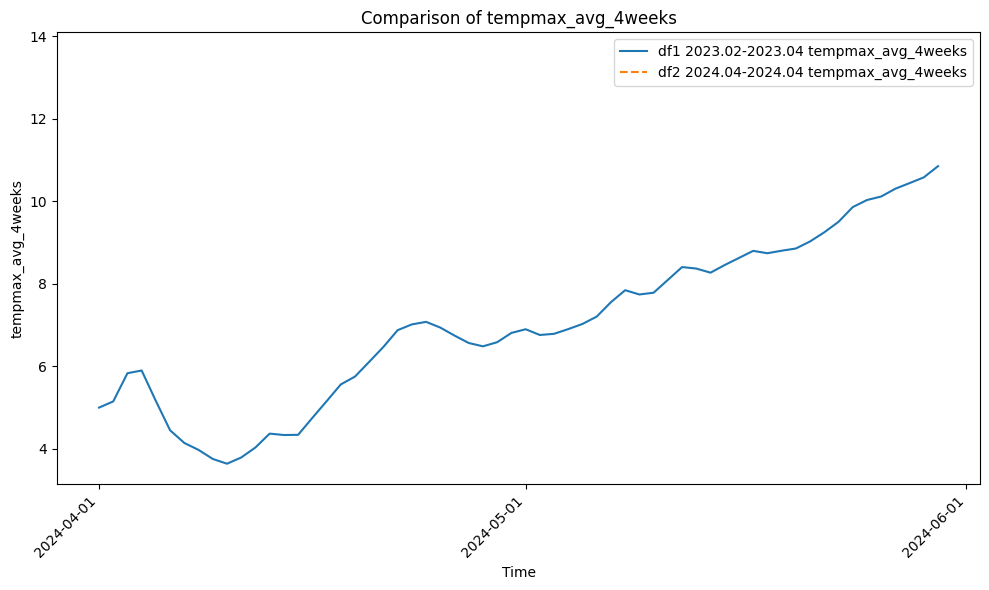

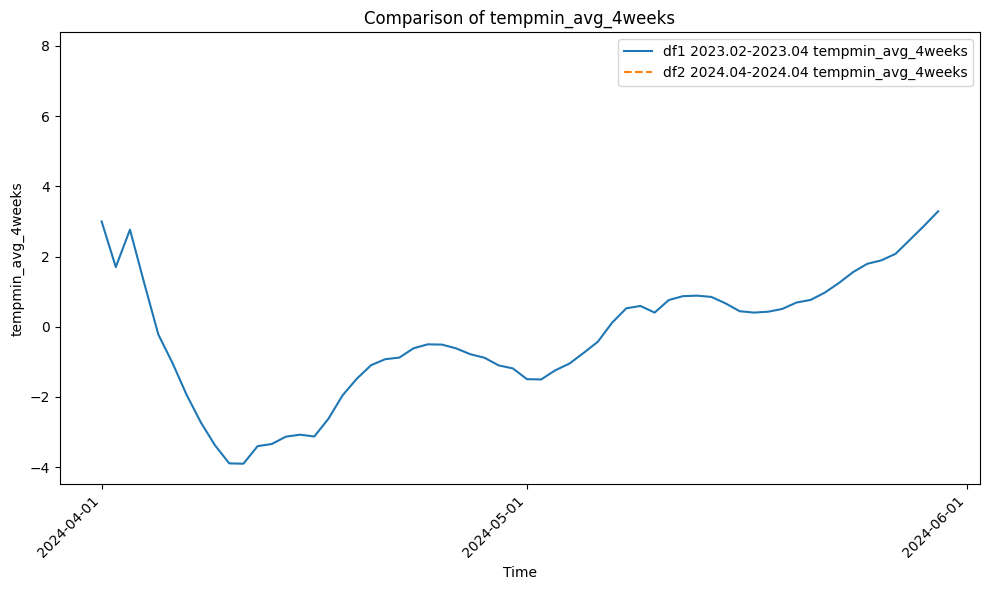

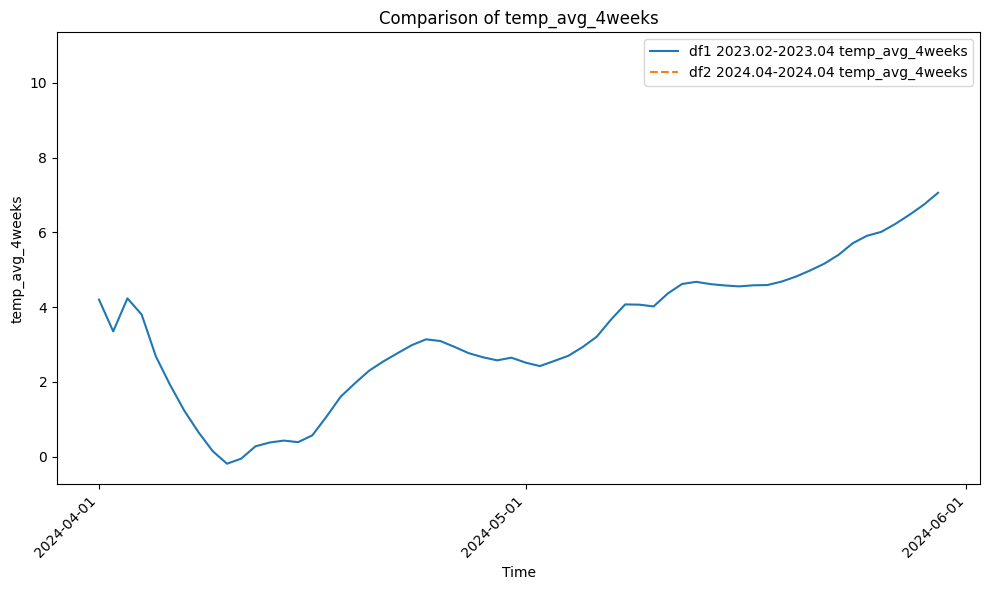

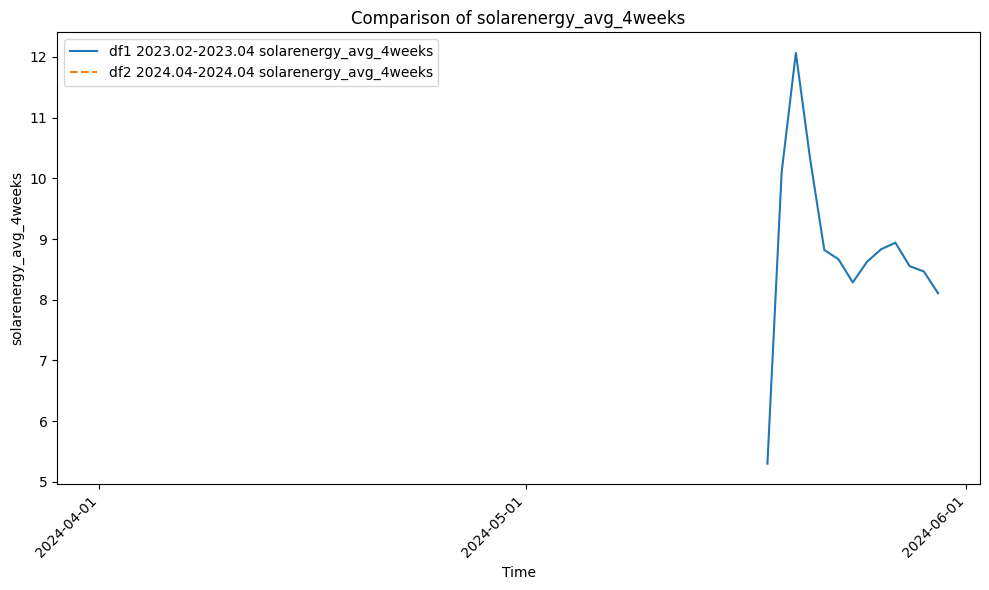

In [2]:
old_start_date = "2023-02-01"
old_end_date = "2023-04-01"
new_start_date = "2024-02-01"
new_end_date = "2024-04-01"
latitude = 49.4521
longitude = 11.0767

run(
    old_start_date=old_start_date,
    old_end_date=old_end_date,
    new_start_date=new_start_date,
    new_end_date=new_end_date,
    latitude=latitude,
    longitude=longitude,
)